In [1]:
import ee
import rasterio
import numpy as np
from pprint import pprint
from IPython.display import display
from IPython.display import Image
import matplotlib.pyplot as plt
from matplotlib import colors

In [2]:
ee.Initialize()

In [3]:
from channel_classifier.internal.ee_utils import add_labels, compute_error_image, download_tiff, get_landsat_images, get_landsat_composite

In [4]:
from channel_classifier.internal.ee_utils import download_rgb_image

In [63]:
def plot_image(images):
    filename = download_tiff(image.clip(image.geometry()), scale=100)
    with rasterio.open(filename) as r:
        im = r.read()
        rgb = np.stack([im[3], im[2], im[1]], axis=-1)
        fig, ax = plt.subplots(1, 1, figsize=(12,12))
        im = ax.imshow(rgb)

In [62]:
from scipy.misc import bytescale
def download_rgb_image(image):
    filename = download_tiff(image, scale=100)
    path = image.get('WRS_PATH').getInfo()
    row = image.get('WRS_ROW').getInfo()
    year = image.date().get('year').getInfo()
    month = image.date().get('month').getInfo()
    day = image.date().get('day').getInfo()
    out_filename = 'L8_{}_{}_{}_{}_{}.png'.format(path, row, year, month, day)

    with rasterio.open(filename) as r:
        # XXX: Assumes Landsat 8 for now
        red = rescale(r.read(4))
        green = rescale(r.read(3))
        blue = rescale(r.read(2))
        label = r.read(r.count)
        profile = r.profile
        profile.update(count=4, driver='PNG', dtype=rasterio.uint8)

    with rasterio.open(out_filename, 'w', **profile) as out:
        dtype = profile['dtype']
        out.write(red.astype(dtype), 1)
        out.write(green.astype(dtype), 2)
        out.write(blue.astype(dtype), 3)
        out.write(label.astype(dtype), 4)
        
    return out_filename

In [54]:
def rescale(band):
    good = band[~np.isinf(band)]
    min_val = np.min(good)
    band[np.isinf(band)] = min_val
    band = bytescale(band)
    return band

In [5]:
path, row = [7, 65] # Ucayali
#path, row = [3, 69] # RMDD
#path, row = [232, 71] # Mamore
start_date = '2013-01-01'
end_date = '2014-01-01'

In [6]:
images = get_landsat_images(path, row, start_date, end_date)
images = images.filter(ee.Filter.lt('CLOUD_COVER', 5))
image = ee.Image(images.first())

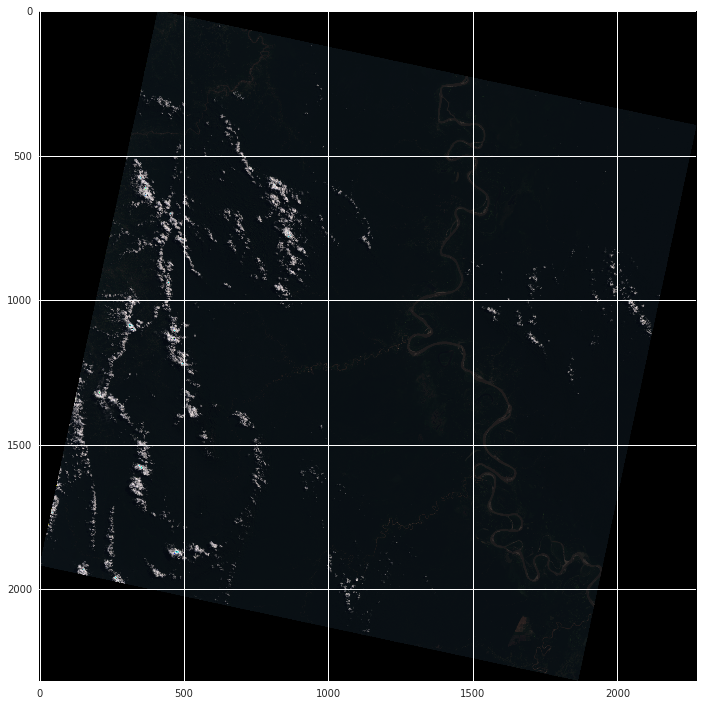

In [64]:
plot_image(image)

In [71]:
def pansharpen(image, bands=['B4', 'B3', 'B2']):
    hsv = image.select(bands).rgbToHsv()
    hue = hsv.select(['hue'])
    sat = hsv.select(['saturation'])
    pan = image.select(['B8'])
    sharpened = ee.Image.cat([hue, sat, pan]).hsvToRgb()
    sharpened.set('system:time_start', image.date().getInfo())
    return sharpened

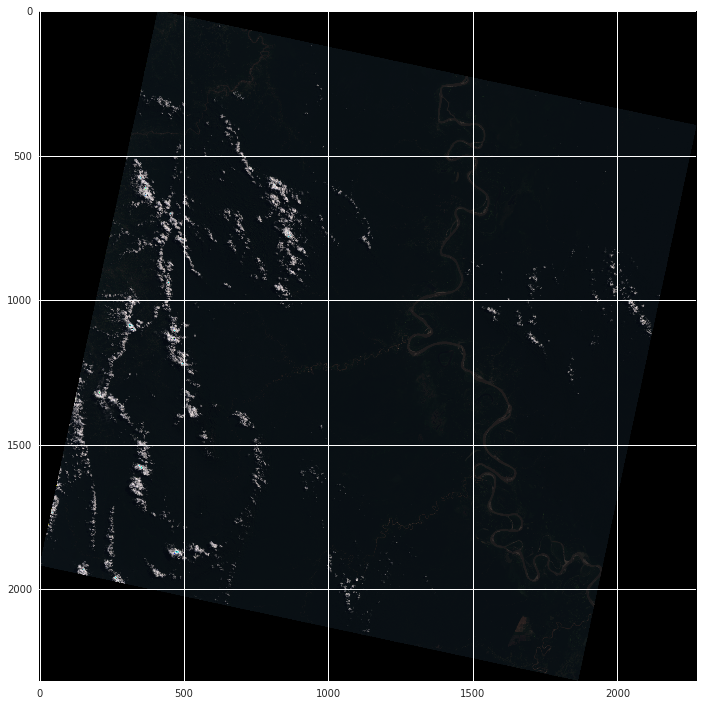

In [72]:
pan = pansharpen(image)
plot_image(pan)

In [73]:
fn = download_rgb_image(pan)
print(fn)

EEException: Image.date: Image does not have a valid system:time_start property!

In [ ]:
from skimage.io import imread
out = imread(fn)
print(out[0].min(), out[0].max())

In [ ]:
print(out.shape)
rgb = out[:, :, 0:3]
print(rgb.shape)
plt.imshow(rgb)